# Draft for PCA (Smoothie King)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# smoothie data merged
smoothie_demo = pd.read_csv('../data/Smoothie King/smoothie_king_demographic_variables.csv')
smoothie_poi = pd.read_csv('../data/Smoothie King/smoothie_king_poi_variables.csv')
smoothie_stores = pd.read_csv('../data/Smoothie King/smoothie_king_stores.csv')
smoothie = pd.merge(smoothie_demo, smoothie_poi, on='store')
smoothie = pd.merge(smoothie, smoothie_stores, on='store')

In [3]:
smoothie.head()

,store,medhhinc_1mi,age0018_1mi,age0018_p_1mi,age65pl_1mi,age65pl_p_1mi,age85pl_1mi,age85pl_p_1mi,asian_1mi,asian_p_1mi,...,transitstop_nearest_dist,transitstops,longitude,latitude,category,cbsa_name,dma_name,state_name,market_size,store_density
0,SK 1504,83846.0042,3774.0,0.2969,1151.0,0.0905,57.0,0.0045,603.0579,0.0474,...,14.818824,0,-97.650392,30.519353,SHOPPING,"Austin-Round Rock, TX","Austin, TX",Texas,Large Metro (2),Light Suburban
1,SK 0057,50388.0216,1688.0,0.2298,1311.0,0.1784,123.0,0.0168,280.1880,0.0381,...,49.572856,0,-88.171150,30.672501,SHOPPING,"Mobile, AL","Mobile et al, AL-FL",Alabama,Medium City (4),Light Suburban
2,SK 1415,59999.1012,3340.0,0.2405,2451.0,0.1765,194.0,0.0140,167.5000,0.0121,...,3.518308,0,-90.535722,38.784250,HOME,"St. Louis, MO-IL","St. Louis, MO",Missouri,Very Large Metro (1),Light Suburban
3,SK 1231,97438.8015,2266.0,0.1938,2476.0,0.2118,224.0,0.0192,414.8301,0.0355,...,0.021790,25,-80.134700,26.100737,TRAVEL,"Miami-Fort Lauderdale et al, FL","Miami-Ft. Lauderdale, FL",Florida,Very Large Metro (1),Suburban
4,SK 1535,56156.2657,9780.0,0.3207,2628.0,0.0862,91.0,0.0030,2148.1145,0.0705,...,0.055289,17,-96.856651,32.996408,WORK,"Dallas-Fort Worth-Arlington, TX","Dallas-Ft. Worth, TX",Texas,Very Large Metro (1),Light Suburban


In [4]:
import os
import random
import sys
import time

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 16
# plt.style.use("seaborn")
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

In [5]:
X_df = smoothie.drop(columns=["store", "category"])

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

X_df = X_df.select_dtypes(include=numerics)

y_df = smoothie['category']

In [6]:
standard_scaler = StandardScaler()
transformed_X = standard_scaler.fit_transform(X_df)
transformed_X = pd.DataFrame(transformed_X).fillna(0)

In [7]:
n_components = 63
pca = PCA(n_components=n_components, whiten=True, random_state=0)
pca.fit(transformed_X)

PCA(n_components=63, random_state=0, whiten=True)

In [8]:
df = pd.DataFrame(
    data=np.cumsum(pca.explained_variance_ratio_),
    columns=["cummulative variance_explained (%)"],
    index=range(1, n_components + 1),
)
df.index.name = "n_components"

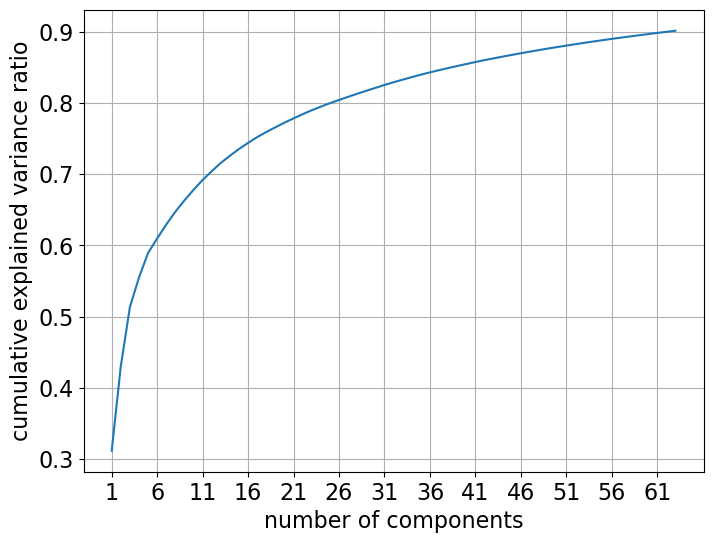

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 64), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1, 64, 5))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance ratio")
plt.grid()
plt.show()

In [10]:
feature_names_out = pca.get_feature_names_out(X_df.columns)
feature_names_out

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14',
       'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21',
       'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28',
       'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35',
       'pca36', 'pca37', 'pca38', 'pca39', 'pca40', 'pca41', 'pca42',
       'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49',
       'pca50', 'pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56',
       'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62'], dtype=object)

In [11]:
transformed_features = pd.DataFrame(abs(pca.components_), columns=X_df.columns, index=feature_names_out)
transformed_features.head()

,medhhinc_1mi,age0018_1mi,age0018_p_1mi,age65pl_1mi,age65pl_p_1mi,age85pl_1mi,age85pl_p_1mi,asian_1mi,asian_p_1mi,avg_faminc_1mi,...,osm_nearest_exit_dist,osm_highway_exits_count_1mi,osm_highway_exits_count_2mi,osm_highway_exits_count_3mi,osm_highway_exits_count_5mi,osm_highway_exits_count_10mi,transitstop_nearest_dist,transitstops,longitude,latitude
pca0,0.009532,0.047764,0.008117,0.043473,0.006105,0.032629,0.003431,0.034905,0.011095,0.012986,...,0.009998,0.012914,0.025482,0.030934,0.034782,0.037445,0.010037,0.030273,0.000829,0.003632
pca1,0.072609,0.005701,0.003103,0.008569,0.000806,0.018019,0.016315,0.021202,0.038922,0.066215,...,0.005331,0.000807,0.005034,0.005396,0.000860,0.011821,0.016632,0.013454,0.003133,0.016910
pca2,0.010400,0.014411,0.033887,0.006830,0.019500,0.001668,0.023097,0.002459,0.004738,0.034500,...,0.002469,0.008991,0.019423,0.023153,0.022829,0.010825,0.000301,0.019912,0.020944,0.030856
pca3,0.007199,0.024505,0.025177,0.033523,0.104020,0.049072,0.084966,0.035233,0.022775,0.005571,...,0.001344,0.002868,0.013678,0.016779,0.007128,0.010465,0.016734,0.000187,0.028629,0.008337
pca4,0.005588,0.017340,0.082336,0.048112,0.056452,0.055927,0.051877,0.012478,0.045002,0.002792,...,0.034455,0.048798,0.051576,0.049926,0.063685,0.066271,0.007057,0.021682,0.047775,0.027912


### Try 1: Filter and Count Important Features (of heavy weights)

Filter the values in the PCA component matrix, and count the occurrence of the features in the filtered matrix.

In [12]:
pca0_df = transformed_features.iloc[0].sort_values(axis=0, ascending=True)
pca0_df.filter(pca0_df > 0.01)

Series([], Name: pca0, dtype: float64)

In [13]:
W = abs(pca.components_)
features = X_df.columns
long_results = []
for i in range(W.shape[0]):
    array = W[i]
    heavy_idx = np.where(array > 0.01)
    long_results += list(features[heavy_idx])

In [14]:
count = pd.Series(long_results).value_counts()
count[:20]

edu_assocdeg_p_2mi                     57
occ_bc_p_10mi                          56
emp_construction_p_3mi                 56
dtpop_students_post_secondary_p_2mi    56
com0811_p_10mi                         56
emp_finance_insurance_p_3mi            56
asian_p_3mi                            55
com0811_p_5mi                          55
emp_finance_insurance_p_2mi            55
genz_1mi                               55
emp_finance_insurance_p_5mi            55
dtpop_students_p_2mi                   55
emp_accommodation_foodserv_p_3mi       55
emp_information_p_5mi                  55
emp_mining_p_5mi                       55
emp_retail_trade_p_5mi                 55
hh_type_male_child_p_3mi               55
emp_retail_trade_p_3mi                 55
hh_5vehicle_p_3mi                      54
emp_wholesale_trade_p_3mi              54
dtype: int64